# Table of Contents

1. [Problem Statement](#pstatement)
2. [Data Loading and Spliting](#dload)
3. [Data Augmentation](#daugment)
4. [Model Building](#mbuild)
5. [Model Training](#mtrain)
6. [Performance Visualization](#pvis)
7. [Model Testing](#mtest)
8. [Performance Measures](#pmeasures)
9. [Qualitative Results](#quality)

# Problem Statement<a id='pstatement'><\a>
To implement an image degmentation pipeline using CNNs to get sementic understanding of the images.


**Monuseg dataset** (available [here](https://monuseg.grand-challenge.org/Data/)) is downloaded and the ground truth segmentation masks are created. The dataset can be either obtained from the instructor or can be downloaded from [this](https://drive.google.com/drive/folders/1hnHjxFb52BdhxkcV_N7MdWLdagzXHzmq?usp=sharing) Google Drive link.

In [1]:
#Imports the print function from newer versions of python
from __future__ import print_function

%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
!rm -r Semantic_Segmentation_Keras

In [3]:
!git clone https://github.com/zeeshanalipnhwr/Semantic-Segmentation-Keras
!mv Semantic-Segmentation-Keras Semantic_Segmentation_Keras

Cloning into 'Semantic-Segmentation-Keras'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1061 (delta 37), reused 0 (delta 0), pack-reused 991
Receiving objects: 100% (1061/1061), 80.25 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (562/562), done.


# Data Loading and Spliting<a id='dload'><\a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip "/content/drive/My Drive/MonuSeg-dataset"

In [0]:
files_path = "./MonuSeg"

In [6]:
from Semantic_Segmentation_Keras.Utils import display, load_data2
import numpy as np

(X_train, X_valid, X_test,
 Y_train, Y_valid, Y_test) = load_data2.load_data(files_path, load_as="rgb", sub_images_size=(256, 256),
                                                  overlap_ratio=.2, validation_size=0.25)

print ("X_train: ", X_train.shape, "\nY_train: ", Y_train.shape)
print ("X_valid: ", X_valid.shape, "\nY_valid: ", Y_valid.shape)
print ("X_test: ", X_test.shape, "\nY_test: ", Y_test.shape)

X_train:  (562, 256, 256, 3) 
Y_train:  (562, 256, 256, 1)
X_valid:  (188, 256, 256, 3) 
Y_valid:  (188, 256, 256, 1)
X_test:  (14, 1000, 1000, 3) 
Y_test:  (14, 1000, 1000, 1)


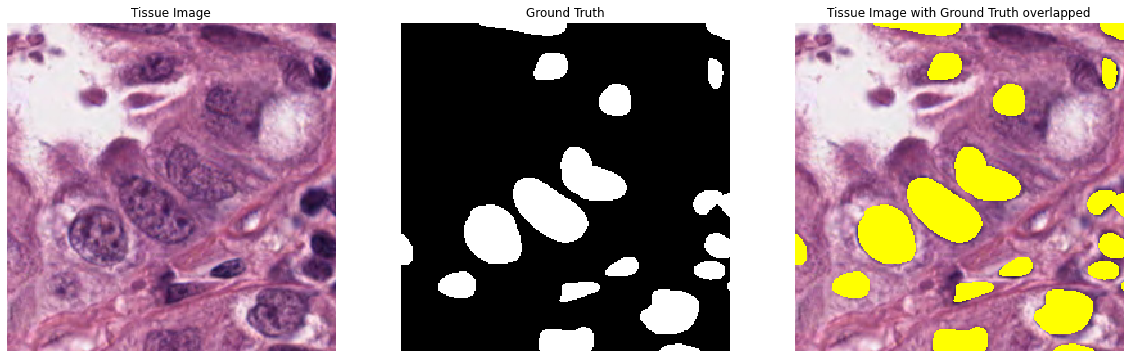

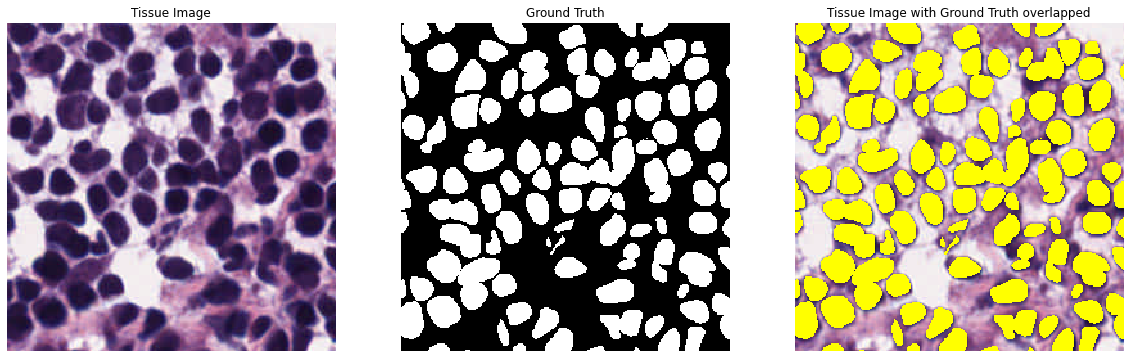

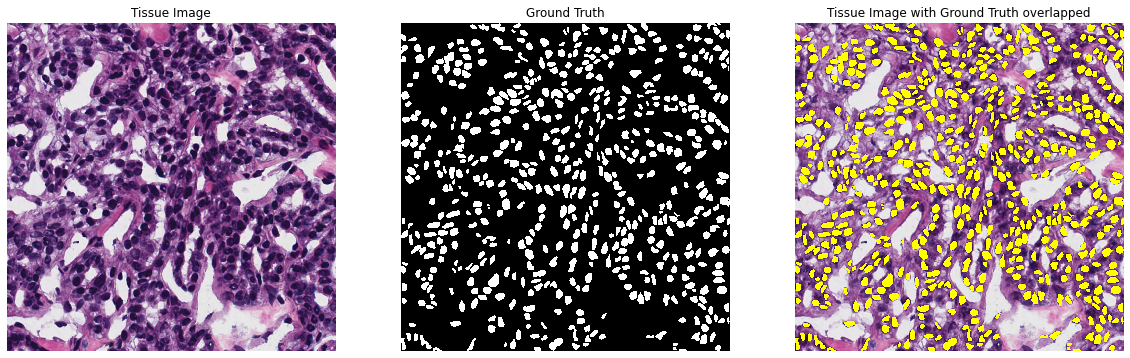

In [7]:
display.display_masked(image=X_train[0], mask=Y_train[0].round(0),
               image_name="Tissue Image", mask_name="Ground Truth")
display.display_masked(image=X_valid[0], mask=Y_valid[0].round(0),
               image_name="Tissue Image", mask_name="Ground Truth")
display.display_masked(image=X_test[0], mask=Y_test[0].round(0),
               image_name="Tissue Image", mask_name="Ground Truth")

Pad zeroes to the test data to reshape them as 1024x1024 from 1000x1000.

In [8]:
X_test_padded = np.zeros((X_test.shape[0], 1024, 1024, 3))
Y_test_padded = np.zeros((Y_test.shape[0], 1024, 1024, 1))
X_test_padded[:, 12:12+1000, 12:12+1000, :] = X_test
Y_test_padded[:, 12:12+1000, 12:12+1000, :] = Y_test
X_test = X_test_padded
Y_test = Y_test_padded
print ("X_test: ", X_test.shape, "\nY_test: ", Y_test.shape)

X_test:  (14, 1024, 1024, 3) 
Y_test:  (14, 1024, 1024, 1)


# Data Augmentation

In [9]:
from Semantic_Segmentation_Keras.Utils import custom_data_augmenter

Using TensorFlow backend.


In [10]:
augmented_X_train, augmented_Y_train = custom_data_augmenter.augment_segmentation_data(X_train, Y_train, rotate=True, flip_horizontal=True, flip_vertical=True,
                                                                                       rotate_percent=.1, flip_horizontal_percent=.1, flip_vertical_percent=.1)
print ("augmented_X_train.shape:", augmented_X_train.shape)

augmented_X_train.shape: (888, 256, 256, 3)


In [11]:
augmented_X_valid, augmented_Y_valid = custom_data_augmenter.augment_segmentation_data(X_valid, Y_valid, rotate=True, flip_horizontal=True, flip_vertical=True,
                                                                                       rotate_percent=.2, flip_horizontal_percent=.2, flip_vertical_percent=.2)
print ("augmented_X_valid.shape:", augmented_X_valid.shape)

augmented_X_valid.shape: (436, 256, 256, 3)


In [0]:
from Semantic_Segmentation_Keras.Configs import DeepLabV3_Configs

from keras.preprocessing.image import ImageDataGenerator

train_loader = ImageDataGenerator().flow(augmented_X_train, augmented_Y_train, batch_size=DeepLabV3_Configs.BATCHSIZE)
valid_loader = ImageDataGenerator().flow(augmented_X_valid, augmented_Y_valid, batch_size=DeepLabV3_Configs.BATCHSIZE)

# flush out this data as we do not need it now
X_train, Y_train, X_valid, Y_valid = None, None, None, None
augmented_X_train, augmented_Y_train = None, None
augmented_X_valid, augmented_Y_valid = None, None

# Model Building<a id='mbuild'><\a>

![DeepLabV3Plus Architecture](https://miro.medium.com/max/1037/1*2mYfKnsX1IqCCSItxpXSGA.png)

In [0]:
from Semantic_Segmentation_Keras.Models import DeepLabV3Plus
from Semantic_Segmentation_Keras.Configs import DeepLabV3_Configs

model = DeepLabV3Plus.DeepLabV3Plus(depth=DeepLabV3_Configs.DEPTH).DeepLabV3Plus(input_shape=(None, None, 3))

In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 3 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 3 128         conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, None, None, 3 9248        batch_normalization_25[0][0]     
____________________________________________________________________________________________

# Model Training<a id='mtrain'><\a>

In [19]:
from Semantic_Segmentation_Keras import train
H = train.train_model_on_augmented_data(model, train_loader, validation_data=valid_loader,
                                        optimizer=DeepLabV3_Configs.OPTIMIZER,
                                        batch_size=DeepLabV3_Configs.BATCHSIZE,
                                        epochs=DeepLabV3_Configs.EPOCHS,
                                        save=True, save_to="drive/My Drive/", save_as="DeepLabV3Plus")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
56/56 [==============================] - 35s 624ms/step - loss: 0.6670 - acc: 0.8119 - f1_score: 0.6186 - val_loss: 0.6505 - val_acc: 0.8391 - val_f1_score: 0.6545
Epoch 2/100
56/56 [==============================] - 15s 275ms/step - loss: 0.6501 - acc: 0.8482 - f1_score: 0.6870 - val_loss: 0.6610 - val_acc: 0.8053 - val_f1_score: 0.6357
Epoch 3/100
56/56 [==============================] - 15s 276ms/step - loss: 0.6425 - acc: 0.8573 - f1_score: 0.7167 - val_loss: 0.6483 - val_acc: 0.8514 - val_f1_score: 0.7169
Epoch 4/100
56/56 [==============================] - 16s 278ms/step - loss: 0.6363 - acc: 0.8645 - f1_score: 0.7348 - val_loss: 0.6568 - val_acc: 0.8512 - val_f1_score: 0.7327
Epoch 5/100
56/56 [==============================] - 16s 280ms/step - loss: 0.6313 - acc: 0.8717 - f1_score: 0.7491 - val_loss: 0.6415 - val_acc: 0.8634 - val_f1_score: 0.7392
Epoch 6/100
56/56 [===

# Performance Visualization<a id='pvis'><\a>

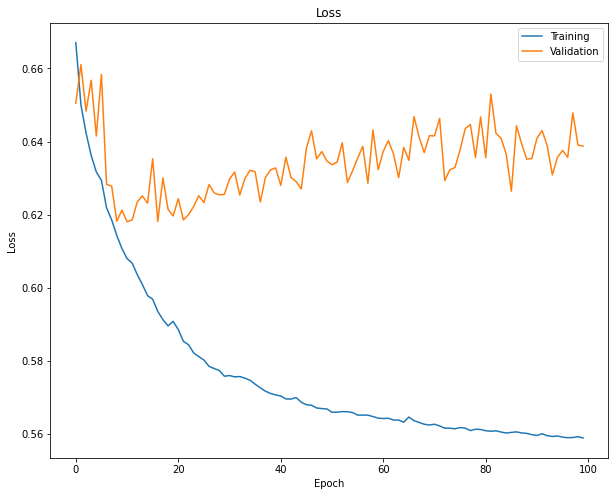

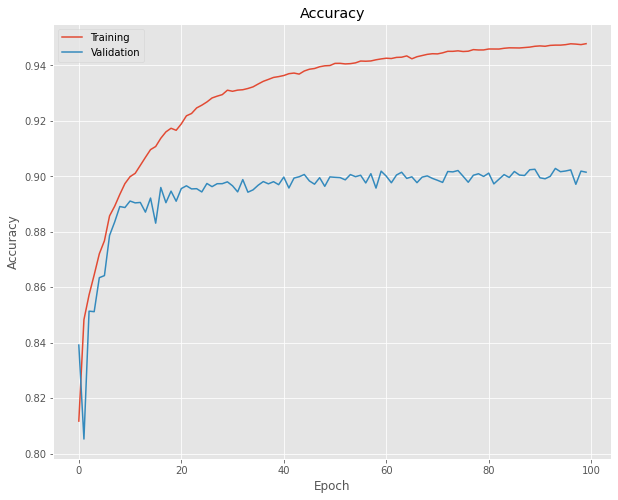

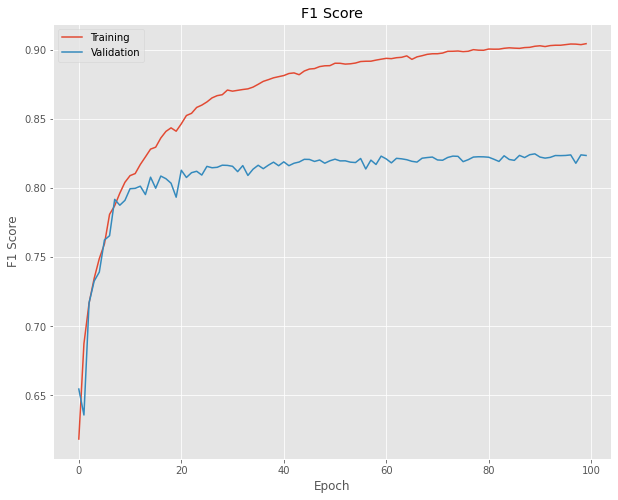

In [20]:
from Semantic_Segmentation_Keras.Utils import display

display.plot_train_valid_performance(H, DeepLabV3_Configs.EPOCHS, save_figures=True,
                                     save_to="drive/My Drive/", model_name="DeepLabV3Plus")

# Model Testing<a id='mtest'><\a>

In [0]:
model.load_weights("drive/My Drive/DeepLabV3Plus.model")

In [0]:
# make predictions on the network
predictions = model.predict(X_test, batch_size=DeepLabV3_Configs.BATCHSIZE//2)

In [0]:
# remove the padded zeros from X_test and Y_test
X_test = X_test[:, 12:12+1000, 12:12+1000, :]
Y_test = Y_test[:, 12:12+1000, 12:12+1000, :]

In [0]:
# discard the predictions for the padded portion of X_train
predictions = predictions[:, 12:12+1000, 12:12+1000, :]

In [25]:
Y_test.shape, predictions.shape

((14, 1000, 1000, 1), (14, 1000, 1000, 1))

# Performance Measures<a id='pmeasures'><\a>

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
TN, FP, FN, TP = confusion_matrix(Y_test.flatten().astype(int),
                             predictions.round(0).flatten().astype(int)).ravel()

In [28]:
TN, FP, FN, TP

(10368792, 865992, 551065, 2214151)

## Accuracy
It is defined as $accuracy = \frac{TP+TN}{TP+FP+TN+FN}$.

In [29]:
print ("Accuracy:", round((TP+TN)/(TP+FP+TN+FN), 4))

Accuracy: 0.8988


## F1 Score (Dice Score)

It is defined as the harmonic mean of precision and recall as $F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$ where $precision=\frac{TP}{TP+FP}$ and $recall=\frac{TP}{TP+FN}$. This simplifies to and hence is equal to the dice score coefficient which is defined as $DSC = \frac{2\times{TP}}{2\times{TP}+FP+FN}$.

In [30]:
precision, recall = TP/(TP+FP), TP/(TP+FN)
print ("F1 Score:", round(2.0/(1.0/precision+1.0/recall), 4))

F1 Score: 0.7576


## Classification Report

In [31]:
print (classification_report(Y_test.round(0).flatten().astype(int), predictions.round(0).flatten().astype(int)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94  11234784
           1       0.72      0.80      0.76   2765216

    accuracy                           0.90  14000000
   macro avg       0.83      0.86      0.85  14000000
weighted avg       0.90      0.90      0.90  14000000



## Confusion Matrix

In [32]:
Confusion_Matrix = ([[TN, FP], [FN, TP]])
Confusion_Matrix

[[10368792, 865992], [551065, 2214151]]

# Qualitative Results

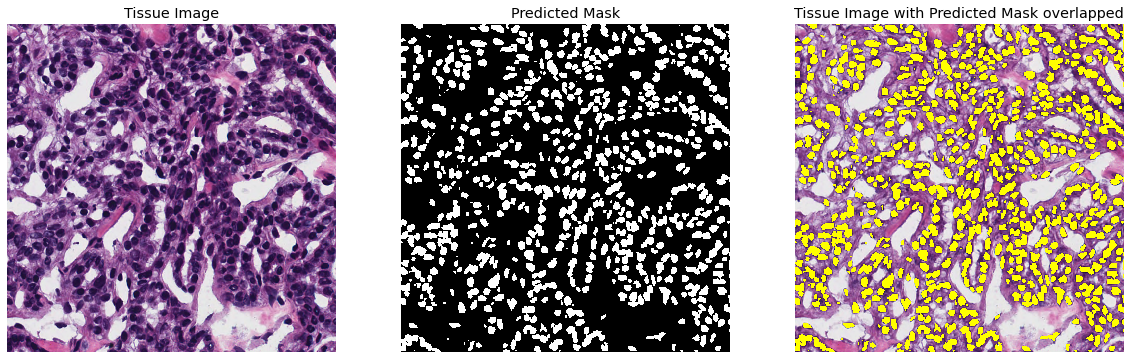

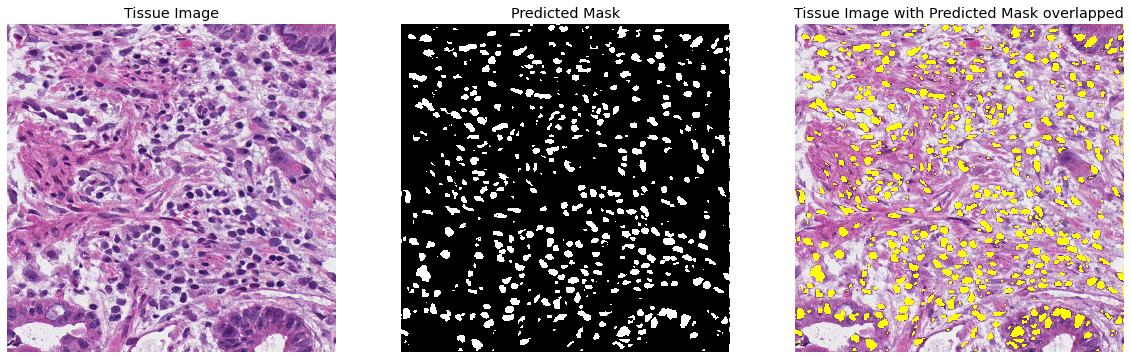

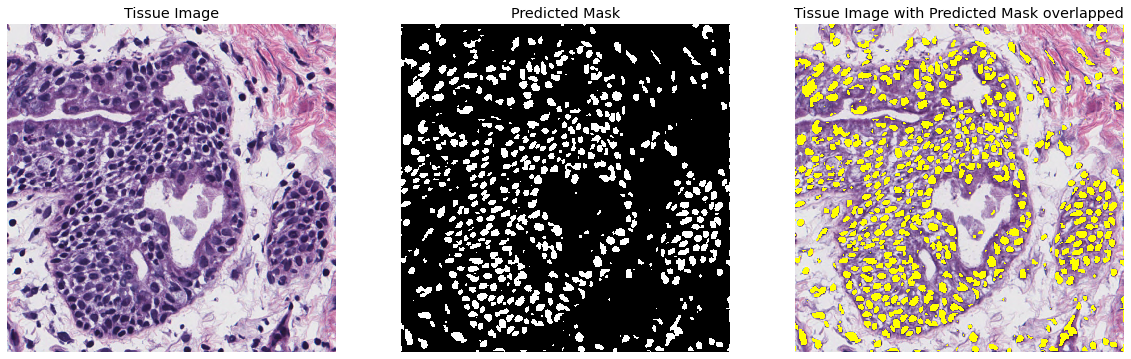

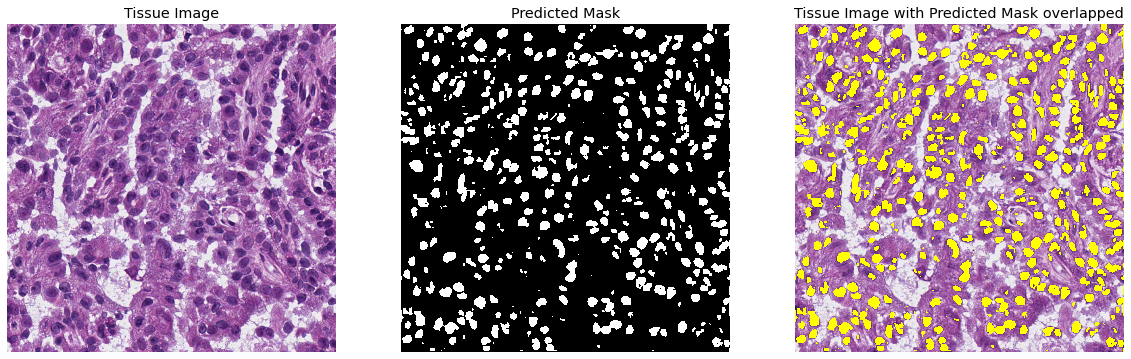

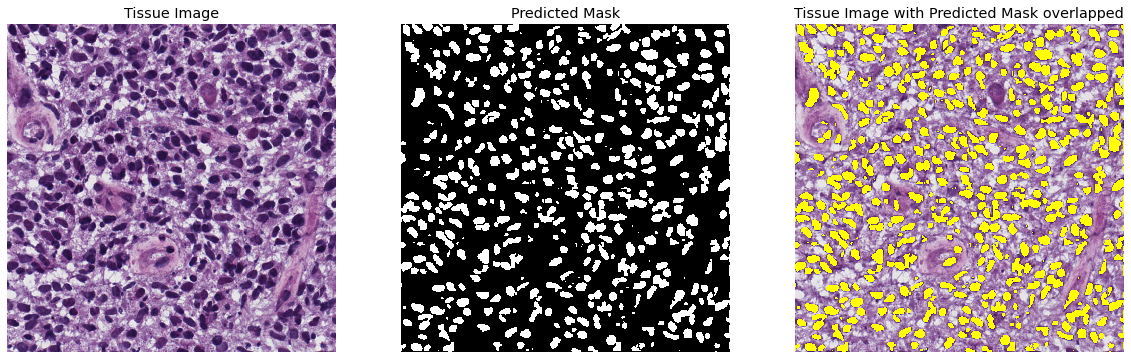

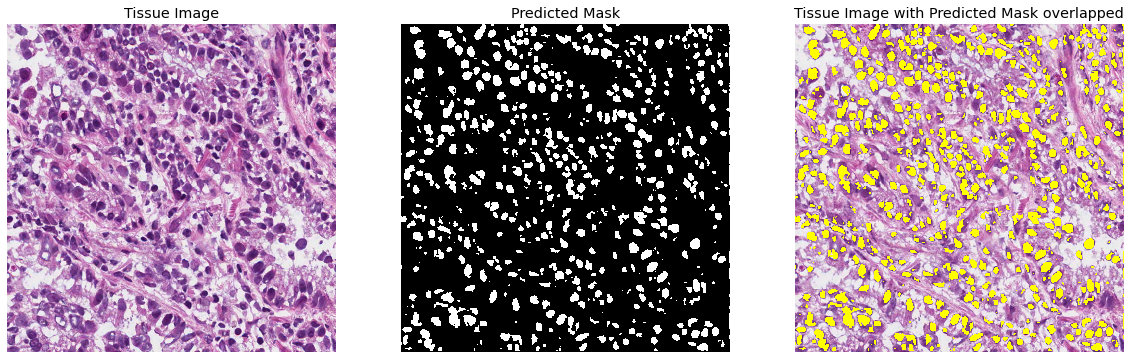

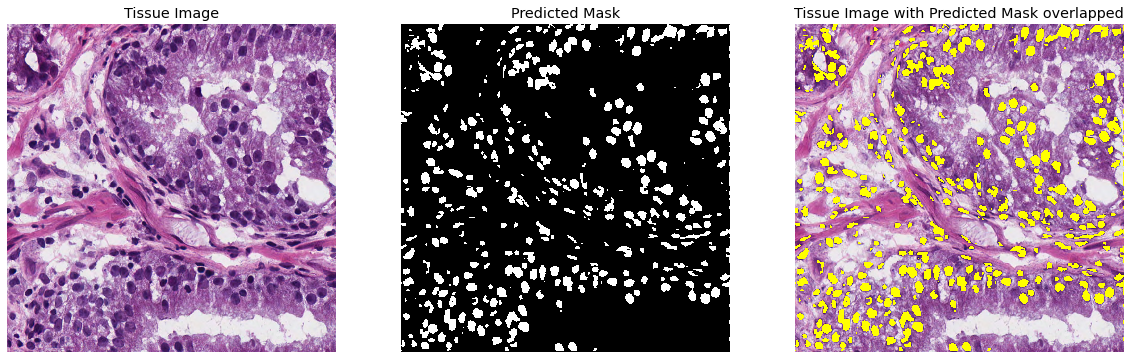

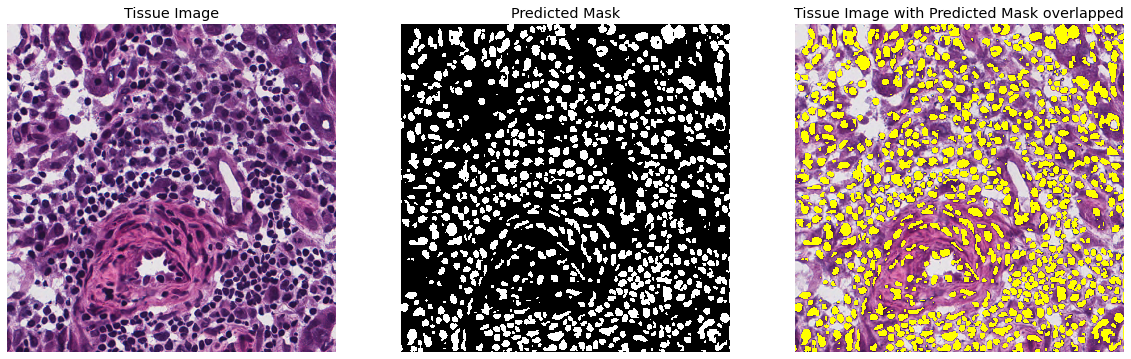

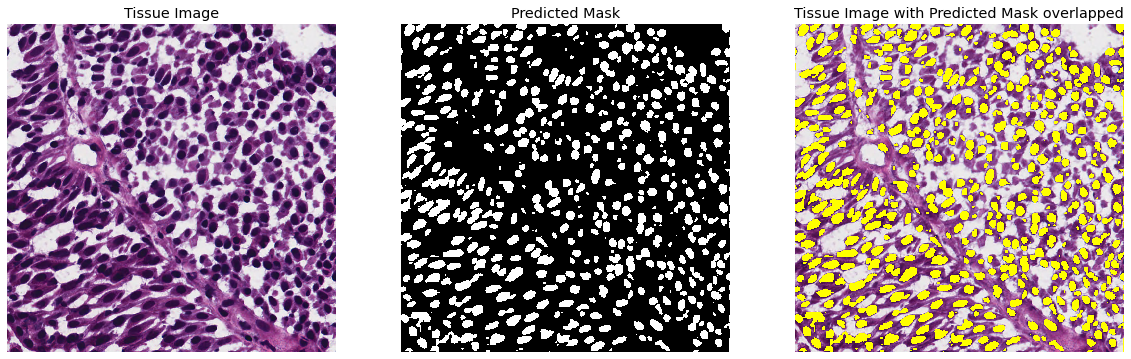

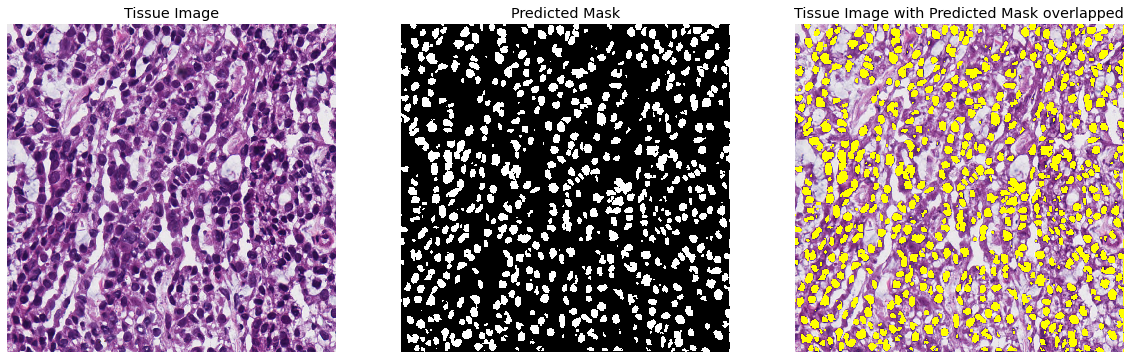

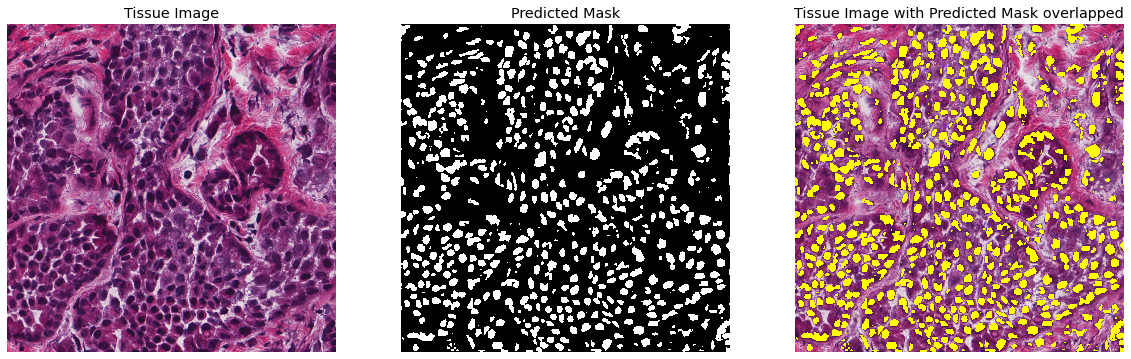

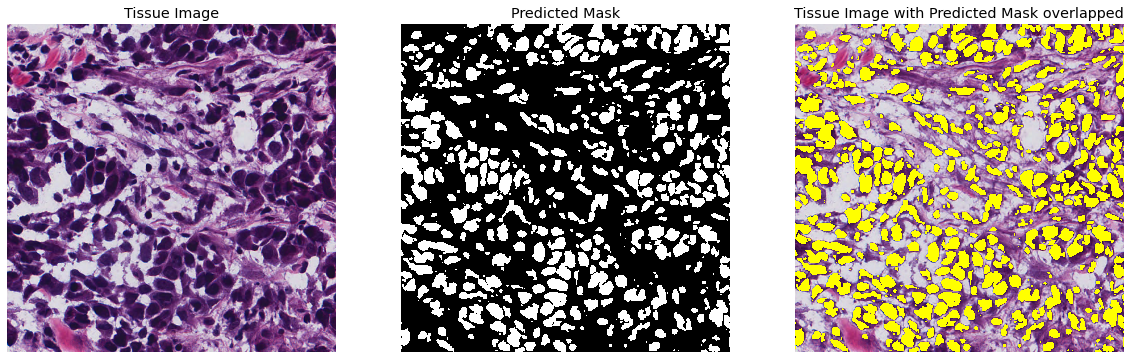

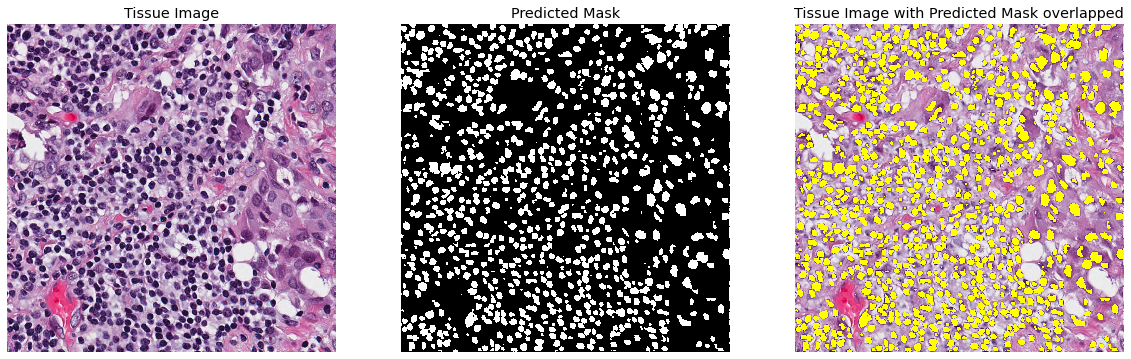

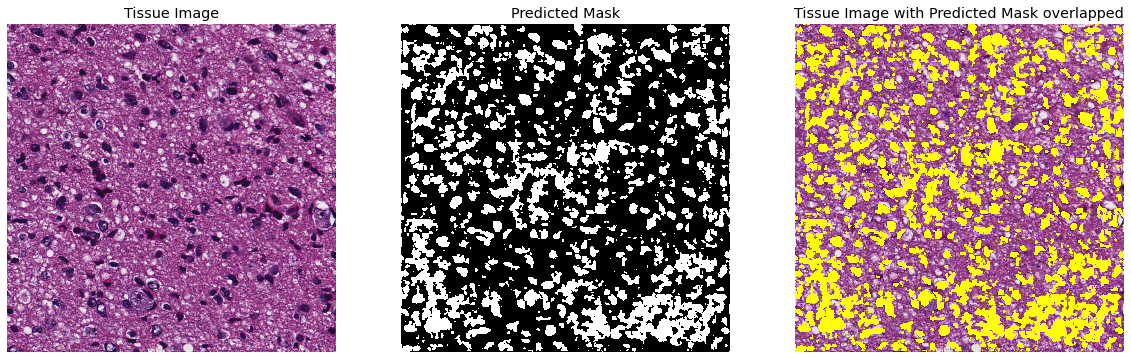

In [33]:
for idx in range(X_test.shape[0]):
    display.display_masked(X_test[idx], predictions[idx].round(0), "Tissue Image", "Predicted Mask")